<h1 align="center">Chinese eligibility criteria classification using convolutional neural network (CNN)</h1>

In this notebook, we will 

<ol>
    <li>train CNN model(from <a href="https://arxiv.org/abs/1408.5882">Convolutional Neural Networks for Sentence Classification</a>) for criteria sentence classification, </li>
    <li>and evalute the performance in test data.</li>
</ol>

Data
* 30644 critering sentences for training
* 7697 critering sentences for testing
* 44 semantic categories

|#|group topics|semantic categories|
|---|---|----
|1|`Health Status`|`Disease` `Symptom` `Sign` `Pregnancy-related Activity` `Neoplasm Status` `Non-Neoplasm Disease Stage` `Allergy Intolerance` `Organ or Tissue Status` `Life Expectancy` `Oral related`
|2|`Treatment or Health Care`|`Pharmaceutical Substance or Drug` `Therapy or Surgery` `Device` `Nursing`
|3|`Diagnostic or Lab Test`|`Diagnostic` `Laboratory Examinations` `Risk Assessment` `Receptor Status`
|4|`Demographic Characteristics`|`Age` `Special Patient Characteristic` `Literacy` `Gender` `Education` `Address` `Ethnicity`
|5|`Ethical Consideration`|`Consent` `Enrollment in other studies` `Researcher Decision` `Capacity` `Ethical Audit` `Compliance with Protocol`
|6|`Lifestyle Choice`|`Addictive Behavior` `Bedtime` `Exercise` `Diet` `Alcohol Consumer` `Sexual related` `Smoking Status` `Blood Donation`
|7|`Data or Patient Source`|`Encounter` `Disabilities` `Healthy` `Data Accessible`
|8|`Other`|`Multiple`

***

load packages

In [1]:
import os
import sys
import time
import codecs
import random
import collections
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import Counter
import tensorflow.keras as kr

import torch
import torch.optim as optim
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

一些设置

In [2]:
SEED = 2021
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Data loader

**训练数据和测试数据路径**

In [3]:
train_data_path = "../data/train.txt"
test_data_path = "../data/test.txt"

In [4]:
train_data = pd.read_csv(train_data_path, sep="\t", header=None, names=["id", "category", "sentence"])
train_data.head(5)

,id,category,sentence
0,s1,Therapy or Surgery,研究开始前30天内，接受过其他临床方案治疗；
1,s2,Sign,（9）严重的听力或者视力损害
2,s3,Addictive Behavior,10)现在或曾经滥用药物或酗酒，或者每天饮用相当于30毫升酒精的酒精饮料。
3,s4,Age,4.年龄小于65岁。
4,s5,Disease,⑧有精神疾病患者；


In [5]:
test_file = "../data/test.txt" 
test_data = pd.read_csv(test_data_path, sep="\t", header=None, names=["id", "category", "sentence"])
test_data.head(5)

,id,category,sentence
0,s1,Multiple,2）性别不限，年龄18～70岁；
1,s2,Multiple,（1）以原发性胃癌为诊断入院，年龄在18岁至70岁之间的患者；
2,s3,Disease,（6）合并造血系统或恶性肿瘤等严重原发性疾病；
3,s4,Researcher Decision,-其他研究者认为不适合参加本研究的患者
4,s5,Capacity,3、儿童家长能回答或看懂研究用量表者。


**读取数据**

In [6]:
def read_file(filename):
    """读取文件数据"""
    contents, labels = [], []
    with codecs.open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                l = line.strip().split('\t')
                content, label = l[2], l[1]
                contents.append(list(content))
                labels.append(label)
            except:
                pass
    return contents, labels

**准备数据字典（词汇表）**<br>
数字字典就是把每个字都对应一个一个数字，包括标点符号

In [7]:
def build_dict(train_data_path, test_data_path, dict_path, vocab_size):
    word_freq = collections.defaultdict(int)
    # 读取已经训练数据
    train_contents, _ = read_file(train_data_path)
    test_contents, _ = read_file(test_data_path)
    
    all_contents = list()
    for words in train_contents+test_contents:
        all_contents.extend(words)

    counter = Counter(all_contents)
    count_pairs = counter.most_common(vocab_size - 1)
    words, _ = list(zip(*count_pairs))
    
    # 添加一个<unk>来表示未知词
    words = ['<unk>'] + list(words)
    # 添加一个 <PAD> 来将所有文本pad为同一长度
    words = ['<PAD>'] + list(words)
    codecs.open(dict_path, mode='w', encoding="utf-8").write('\n'.join(words) + '\n')

读取数据字典（词汇表）

In [8]:
def read_vocab(vocab_dir):
    words = codecs.open(vocab_dir, 'r', encoding='utf-8').read().strip().split('\n')
    word2id = dict(zip(words, range(len(words))))
    id2word = dict(zip(range(len(words)), words))
    return words, word2id, id2word

读取分类类别

In [9]:
def label_id():
    labels = ["Disease","Symptom","Sign","Pregnancy-related Activity","Neoplasm Status","Non-Neoplasm Disease Stage",
            "Allergy Intolerance","Organ or Tissue Status","Life Expectancy","Oral related",
            "Pharmaceutical Substance or Drug","Therapy or Surgery","Device","Nursing","Diagnostic",
            "Laboratory Examinations","Risk Assessment","Receptor Status","Age","Special Patient Characteristic",
            "Literacy","Gender","Education","Address","Ethnicity","Consent","Enrollment in other studies",
            "Researcher Decision","Capacity","Ethical Audit","Compliance with Protocol","Addictive Behavior",
            "Bedtime","Exercise","Diet","Alcohol Consumer","Sexual related","Smoking Status","Blood Donation",
            "Encounter","Disabilities","Healthy","Data Accessible","Multiple"]
    label2id = dict()
    id2label = dict()
    for (i, label) in enumerate(labels):
        label2id[label] = i
        id2label[i] = label
    return labels, label2id, id2label

将文件转换为id表示

In [10]:
def process_file(filename, word2id, label2id, max_length=50):
    contents, labels = read_file(filename)

    data_id, label_id = [], []
    for i in range(len(contents)):
        data_id.append([word2id[x] if x in word2id else word2id['<unk>'] for x in contents[i] ])
        label_id.append(label2id[labels[i]])

    # 使用keras提供的pad_sequences来将文本pad为固定长度
    x_pad = kr.preprocessing.sequence.pad_sequences(data_id, max_length, padding='post')
    y_pad = kr.utils.to_categorical(label_id, num_classes=len(label2id))  # 将标签转换为one-hot表示
    return x_pad, y_pad

In [11]:
# 载入字典
VOCAB_SIZE = 5000
VOCAB_PATH = "dict.txt"
print("loading word vocabulary dict......")
build_dict(train_data_path, test_data_path, dict_path=VOCAB_PATH, vocab_size=VOCAB_SIZE)
words, word2id, id2word = read_vocab(VOCAB_PATH)
print("word dict length：{}".format(len(words)))

# 载入类别
print("loading category tags......")
labels, label2id, id2label = label_id()
print("categories number：{}".format(len(labels)))

# 载入训练数据
print ("Reading training data......")
train_X, train_y = process_file(train_data_path, word2id, label2id, max_length=50)
print("train X shape: ", train_X.shape, "train y shape: ", train_y.shape)

# 载入测试数据
print ("Reading testing  data......")
test_X, test_y = process_file(test_data_path, word2id, label2id, max_length=50)
print("test X shape: ", test_X.shape, "test y shape: ", test_y.shape)

loading word vocabulary dict......
word dict length：2656
loading category tags......
categories number：44
Reading training data......
train X shape:  (30644, 50) train y shape:  (30644, 44)
Reading testing  data......
test X shape:  (7697, 50) test y shape:  (7697, 44)


**生成批次数据**

In [12]:
def batch_iter(x, y, batch_size):
    data_len = len(x)
    num_batch = int((data_len - 1) / batch_size) + 1

    indices = np.random.RandomState(seed=SEED).permutation(np.arange(data_len))
    x_shuffle = x[indices]
    y_shuffle = y[indices]

    for i in range(num_batch):
        start_id = i * batch_size
        end_id = min((i + 1) * batch_size, data_len)
        yield x_shuffle[start_id:end_id], y_shuffle[start_id:end_id]

## Build the Model

In [13]:
N_EPOCHS = 10 # 训练轮数
EMBEDDING_DIM = 256 # 词向量的维度
BATCH_SIZE = 128 # batch大小
learning_rate = 1e-3 # 学习率

### model

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx):
        
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.conv_0 = nn.Conv2d(in_channels = 1, out_channels = n_filters, kernel_size = (filter_sizes[0], embedding_dim))       
        self.conv_1 = nn.Conv2d(in_channels = 1, out_channels = n_filters, kernel_size = (filter_sizes[1], embedding_dim))     
        self.conv_2 = nn.Conv2d(in_channels = 1, out_channels = n_filters, kernel_size = (filter_sizes[2], embedding_dim))      
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)      
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):         
        #text = [batch size, sent len]  
        embedded = self.embedding(x)
                
        #embedded = [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        #pooled_n = [batch size, n_filters]
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]    
        return self.fc(cat)

create an instance of our CNN class

In [15]:
INPUT_DIM = len(words)
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 44 # 类别数目
DROPOUT = 0.5
PAD_IDX = word2id["<PAD>"]
model = TextCNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

Checking the number of parameters in our model

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,000,680 trainable parameters


### train

**optimizer and loss**

In [17]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

**calculate accuracy**

In [18]:
def binary_accuracy(preds, y):
    rounded_preds = torch.argmax(F.softmax(preds, dim=1), 1)
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

**training model**

In [19]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = list()
    epoch_acc = list()
    model.train()
    for batch_x, batch_y in iterator:
        batch_x = torch.from_numpy(batch_x).to(device)
        batch_y = torch.argmax(torch.from_numpy(batch_y), dim=1).to(device)
        optimizer.zero_grad()
        predictions = model(batch_x).squeeze(1)
        loss = criterion(predictions, batch_y)
        acc = binary_accuracy(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
        epoch_acc.append(acc.item())
    return sum(epoch_loss) / len(epoch_loss), sum(epoch_acc) / len(epoch_acc)

**testing model**

In [20]:
def evaluate(model, iterator, criterion):
    epoch_loss = list()
    epoch_acc = list()
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in iterator:
            batch_x = torch.from_numpy(batch_x).to(device)
            batch_y = torch.argmax(torch.from_numpy(batch_y), dim=1).to(device)
            predictions = model(batch_x).squeeze(1)
            loss = criterion(predictions, batch_y)         
            acc = binary_accuracy(predictions, batch_y)
            epoch_loss.append(loss.item())
            epoch_acc.append(acc.item())
    return sum(epoch_loss) / len(epoch_loss), sum(epoch_acc) / len(epoch_acc)

**how long epochs take**

In [21]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

**training loop**

In [22]:
best_test_loss = float('inf')
history = defaultdict(list)

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_iterator = batch_iter(train_X, train_y, batch_size=BATCH_SIZE)
    test_iterator = batch_iter(test_X, test_y, batch_size=BATCH_SIZE)
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    test_loss, test_acc = evaluate(model, test_iterator, criterion)
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['test_acc'].append(test_acc)
    history['test_loss'].append(test_loss)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'best_CNNmodel_state.pt')
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s ',
         f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
         f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 9s  	Train Loss: 1.218 | Train Acc: 65.83% 	Test Loss: 0.741 | Test Acc: 76.88%
Epoch: 02 | Epoch Time: 0m 9s  	Train Loss: 0.779 | Train Acc: 76.31% 	Test Loss: 0.647 | Test Acc: 79.37%
Epoch: 03 | Epoch Time: 0m 9s  	Train Loss: 0.634 | Train Acc: 80.29% 	Test Loss: 0.604 | Test Acc: 80.61%
Epoch: 04 | Epoch Time: 0m 9s  	Train Loss: 0.545 | Train Acc: 82.68% 	Test Loss: 0.589 | Test Acc: 81.33%
Epoch: 05 | Epoch Time: 0m 9s  	Train Loss: 0.466 | Train Acc: 84.86% 	Test Loss: 0.585 | Test Acc: 81.52%
Epoch: 06 | Epoch Time: 0m 9s  	Train Loss: 0.417 | Train Acc: 86.39% 	Test Loss: 0.607 | Test Acc: 81.42%
Epoch: 07 | Epoch Time: 0m 9s  	Train Loss: 0.370 | Train Acc: 88.14% 	Test Loss: 0.605 | Test Acc: 82.02%
Epoch: 08 | Epoch Time: 0m 9s  	Train Loss: 0.327 | Train Acc: 89.46% 	Test Loss: 0.633 | Test Acc: 81.43%
Epoch: 09 | Epoch Time: 0m 9s  	Train Loss: 0.309 | Train Acc: 89.91% 	Test Loss: 0.640 | Test Acc: 81.77%
Epoch: 10 | Epoch Time: 0m 9s  	Train

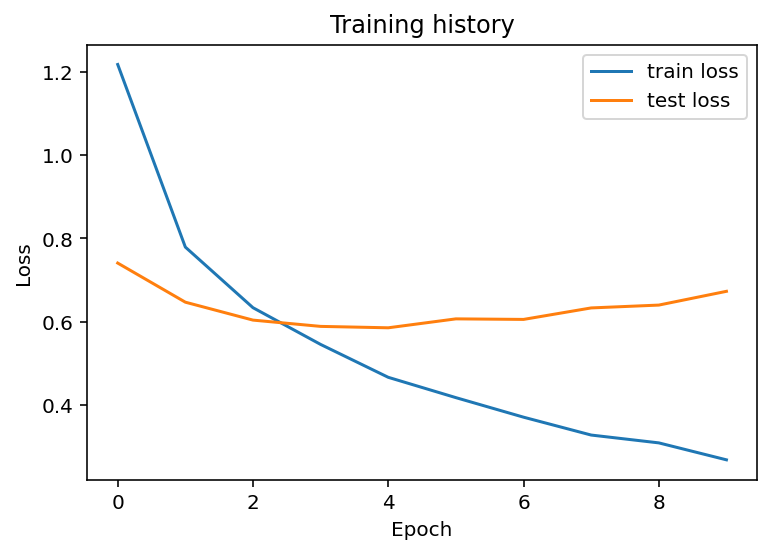

In [23]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='test loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
# plt.ylim([0, 1])

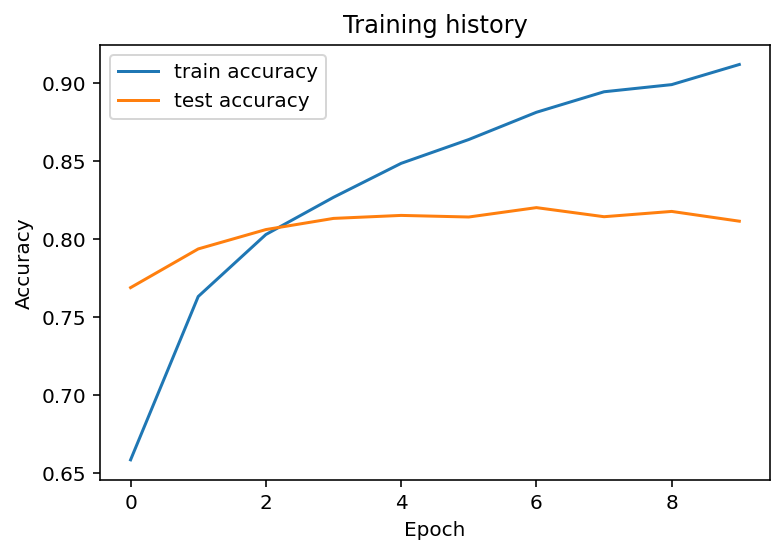

In [24]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='test accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
# plt.ylim([0, 1])

### predict

In [25]:
model.load_state_dict(torch.load('best_CNNmodel_state.pt'))

test_X_ = torch.from_numpy(test_X).to(device)
predictions = model(test_X_).squeeze(1)
pred_probility = F.softmax(predictions, dim=1)

pred_test = list()
np_data = pred_probility.cpu().data.numpy()
for i, probability in enumerate(np_data):
    prob = probability.tolist()
    category = id2label[prob.index(max(prob))]
    pred_test.append(category)

**save predict results**

In [26]:
with codecs.open("CNN_test_pred.txt", "w", encoding="utf-8") as outf:
    for (i, c, s) in zip(test_data["id"], pred_test, test_data["sentence"]):
        outf.write("{}\t{}\t{}\r\n".format(i, c, s))

### evaluation

show predict results by confusion matrix

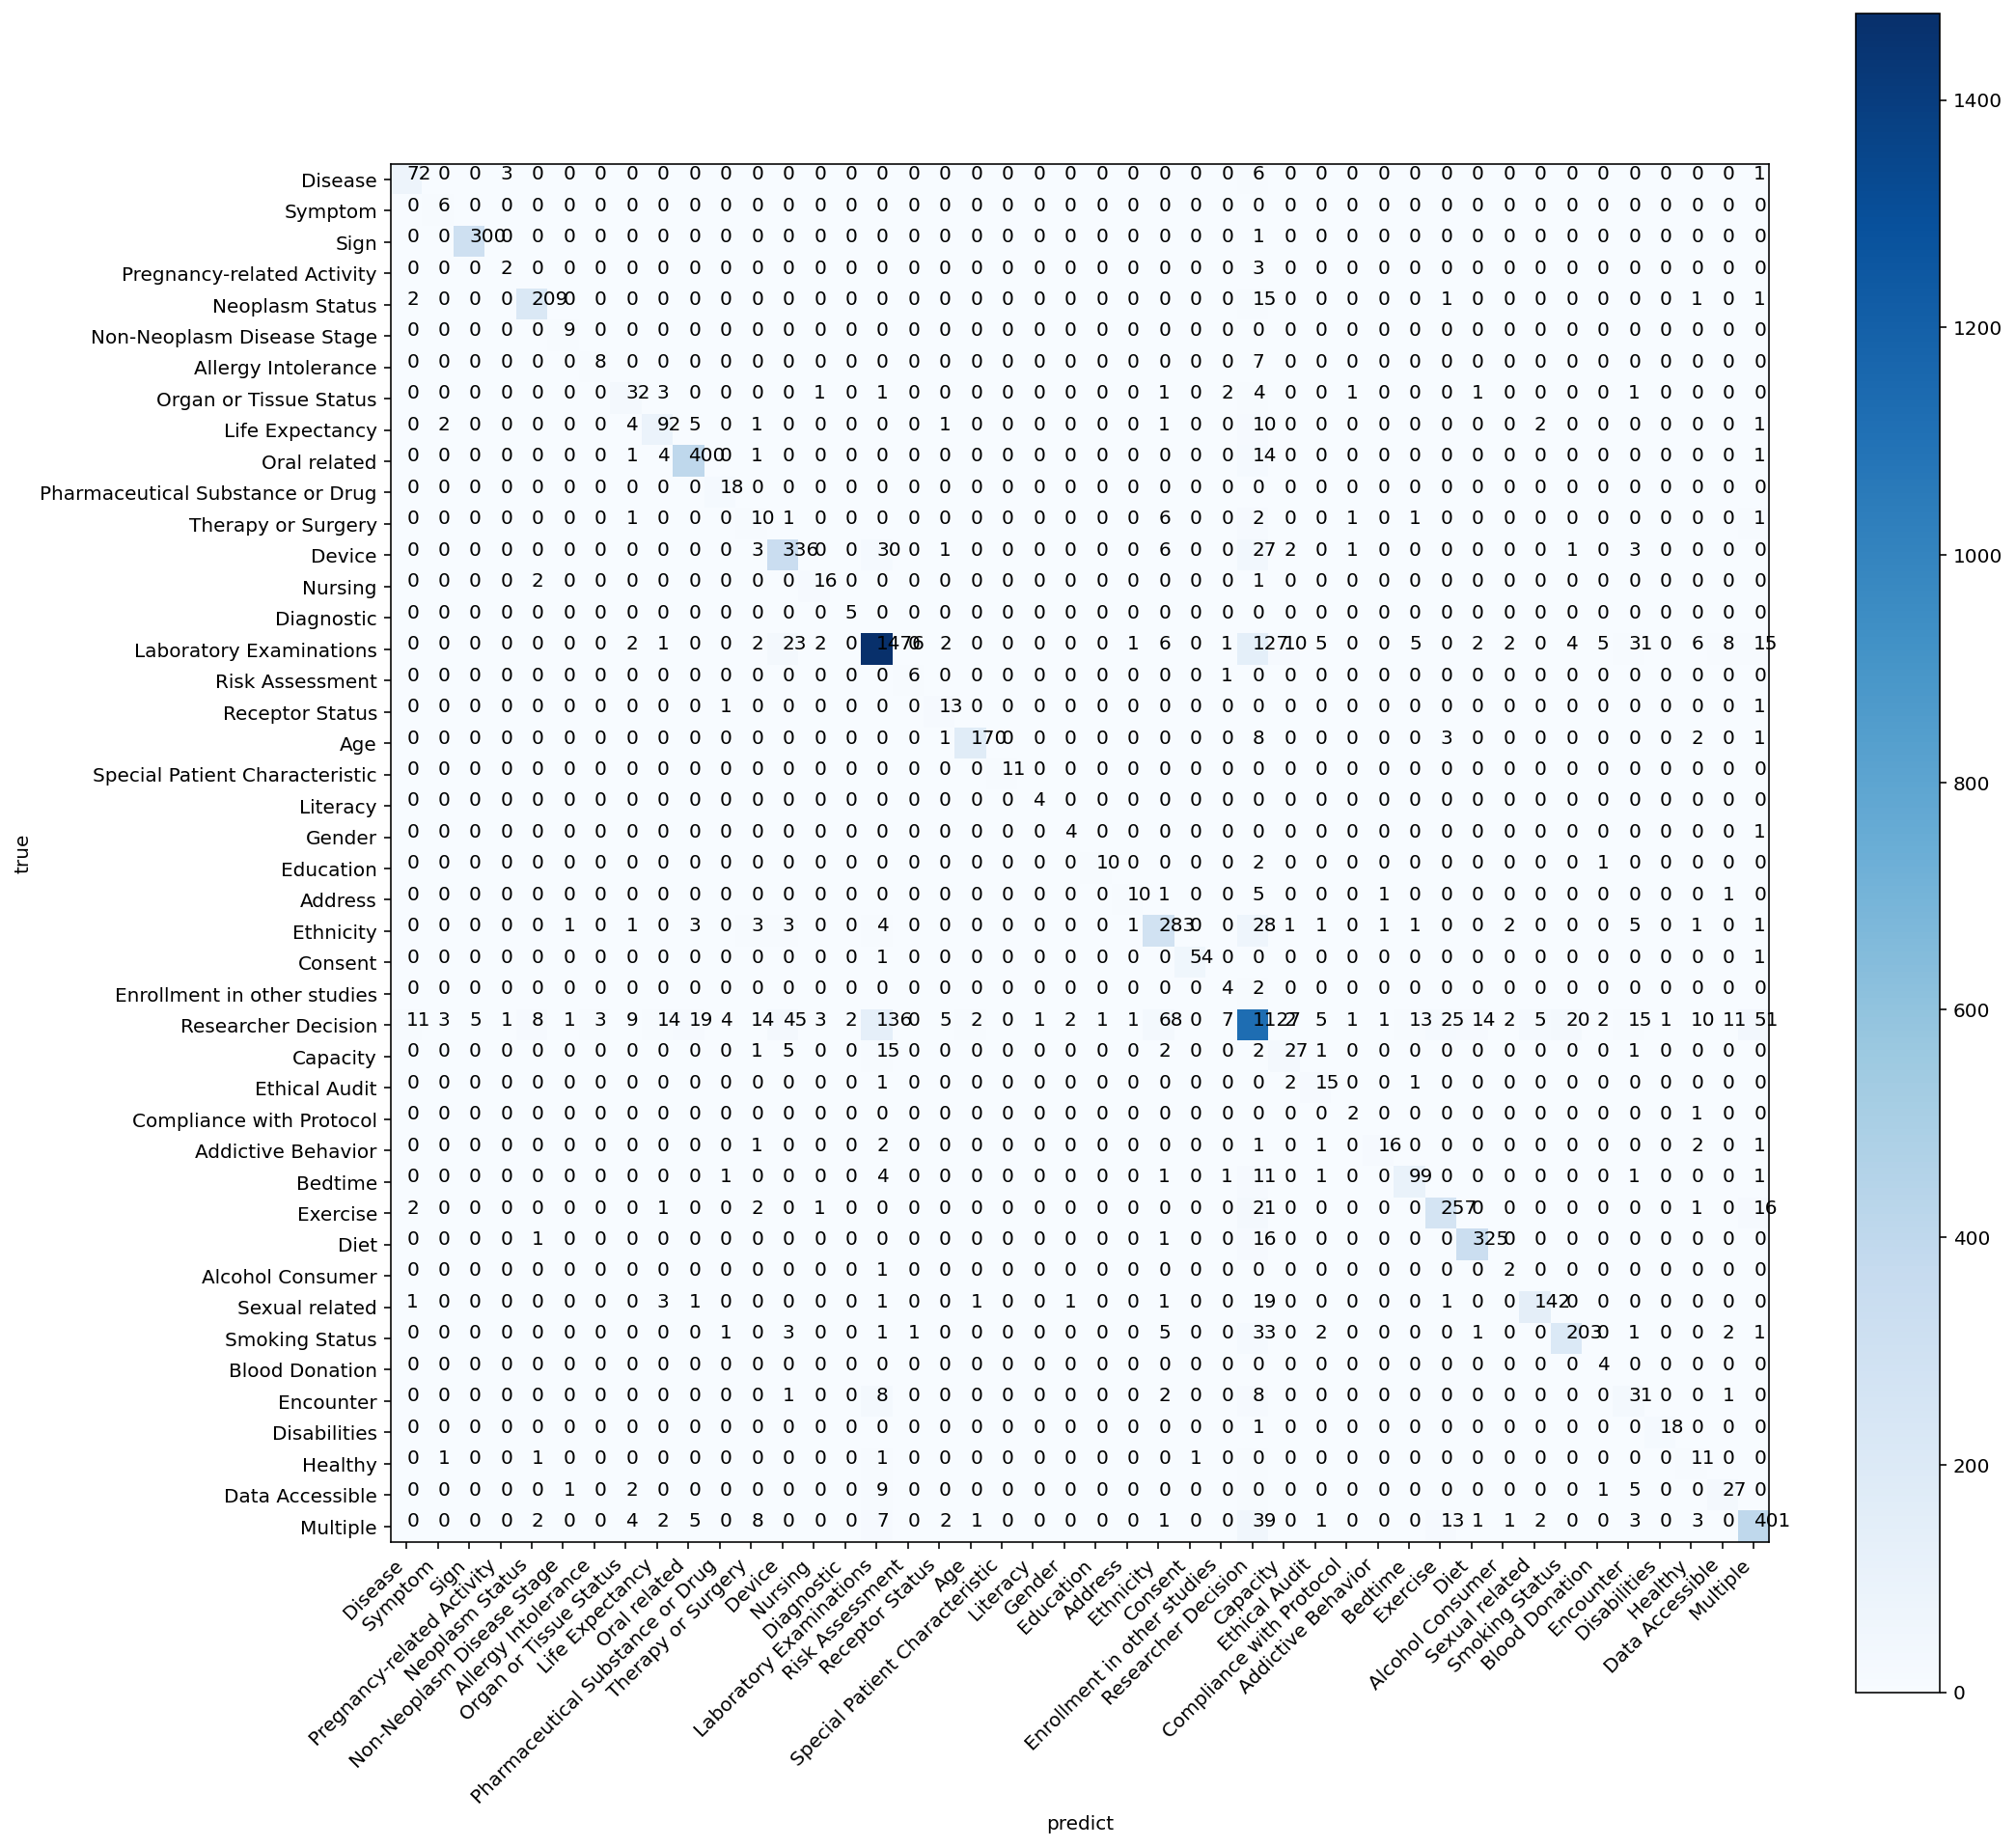

In [27]:
y_test = test_data["category"]
confusion = confusion_matrix(y_test, pred_test)
plt.figure(figsize=(16,16))
plt.imshow(confusion, cmap=plt.cm.Blues)
indices = range(len(confusion))
plt.xticks(indices, labels, rotation=45, ha='right')
plt.yticks(indices, labels)
plt.colorbar()
plt.xlabel('predict')
plt.ylabel('true')
for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index])

precision, recall, F1 score

In [28]:
import evaluation # our defined evaluation metrics.
results = evaluation.Record_results('../data/test.txt', 'CNN_test_pred.txt')
evaluation = evaluation.Evaluation(results.records)

**************************************** Evaluation results*****************************************
                                       Precision.       Recall.          f1.            
                 Addictive Behavior    0.8780           0.8182           0.8471         
                            Address    1.0000           0.5000           0.6667         
                                Age    0.9967           0.9836           0.9901         
                   Alcohol Consumer    0.4000           0.3333           0.3636         
                Allergy Intolerance    0.9127           0.9372           0.9248         
                            Bedtime    1.0000           0.7500           0.8571         
                     Blood Donation    0.5333           0.7273           0.6154         
                           Capacity    0.6809           0.5714           0.6214         
           Compliance with Protocol    0.7731           0.7667           0.7699         
         

**parameters combinations**<br>
* Epoch:10
* EMBEDDING_DIM: 128,256
* Batch size: 64, 128, 256
* Learning rate (Adam): 1e-4, 1e-3, 1e-2

|#|EMBEDDING_DIM|Batch size|Learning rate|train accuracy|test accuracy|test macro-F1|
|---|---|---|---|---|---|----
|1|128|256|1e-4|70.62|73.95|0.334754|
|2|128|256|**1e-3**|86.66|81.87|0.709377|
|3|128|256|1e-2|81.88|78.58|0.608544|
|||||||
|4|128|**128**|1e-3|88.28|81.37|0.710397|
|5|128|64|1e-3|89.49|81.85|0.709654|
||||||||
|6|**256**|128|1e-3|91.21|81.15|0.725814|
|7|512|128|1e-3|91.92|81.06|0.712100|

## References
* [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1408.5882)
* https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb